<a href="https://colab.research.google.com/github/hoangnguyenbao079/Apple_stocks_predict/blob/main/Apple_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import yfinance as yf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

#Define start day to fetch the dataset from the yahoo finance library

In [11]:
# Tạo Spark session
spark = SparkSession.builder.appName("StockDataProcessing").getOrCreate()

# Thiết lập thời gian tải dữ liệu
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

In [12]:
# Hàm tải dữ liệu từ Yahoo Finance
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [18]:
# Bước 1: Tải dữ liệu từ Yahoo Finance
df = load_data("AAPL")

# ✅ Xử lý tên cột: xoá multi-level index
df.columns = [col if not isinstance(col, tuple) else col[0] for col in df.columns]

# ✅ In lại tên cột để kiểm tra
print(df.columns)

# Bước 2: Tạo Spark DataFrame từ Pandas
df_spark = spark.createDataFrame(df)


[*********************100%***********************]  1 of 1 completed

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


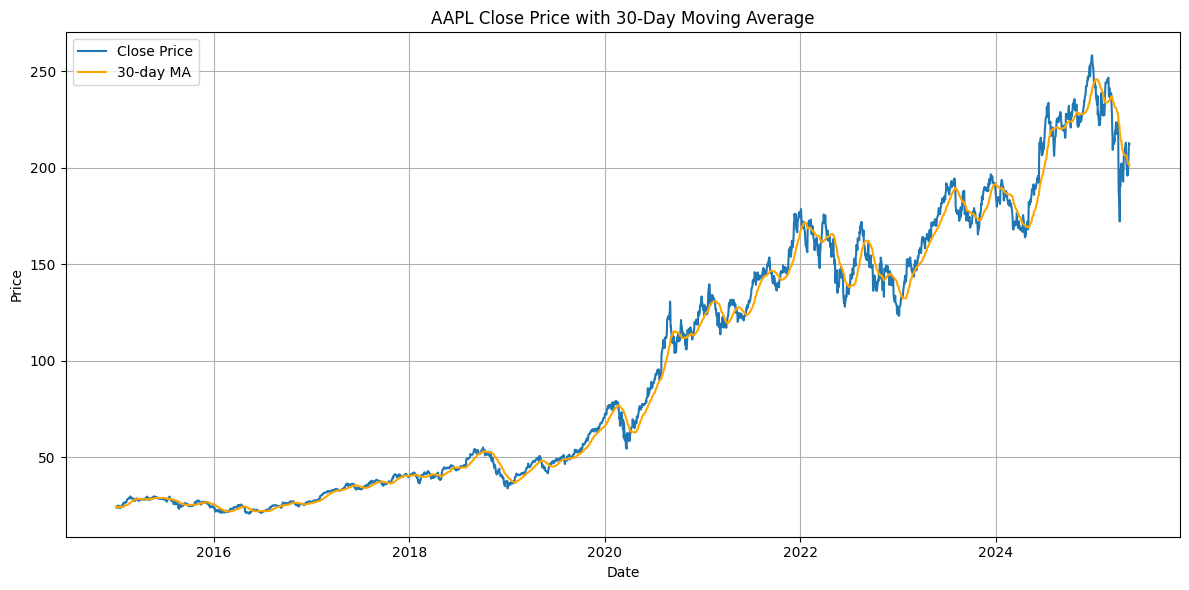

In [20]:
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

# Đảm bảo cột 'Date' là kiểu ngày
df_spark = df_spark.withColumn("Date", to_date(col("Date")))

# Giữ lại các cột cần thiết
df_spark = df_spark.select("Date", "Close")

# Tính MA 30 ngày
windowSpec = Window.orderBy("Date").rowsBetween(-29, 0)
df_spark = df_spark.withColumn("MA_30", avg("Close").over(windowSpec))

# Sắp xếp theo ngày
df_spark = df_spark.orderBy("Date")

# Chuyển về Pandas để vẽ
df_plot = df_spark.toPandas()

# Vẽ biểu đồ
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_plot["Date"], df_plot["Close"], label="Close Price")
plt.plot(df_plot["Date"], df_plot["MA_30"], label="30-day MA", color="orange")
plt.title("AAPL Close Price with 30-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
